In [12]:
import csv
import os
import re
import tensorflow as tf

from object_detection import evaluator
from object_detection.core import standard_fields
from object_detection.metrics import tf_example_parser
from object_detection.utils import config_util
from object_detection.utils import label_map_util

import numpy as np
# flags = tf.app.flags
# tf.logging.set_verbosity(tf.logging.INFO)

# flags.DEFINE_string('eval_dir', None, 'Directory to write eval summaries to.')
# flags.DEFINE_string('eval_config_path', None,
#                     'Path to an eval_pb2.EvalConfig config file.')
# flags.DEFINE_string('input_config_path', None,
#                     'Path to an eval_pb2.InputConfig config file.')

# FLAGS = flags.FLAGS

In [13]:
def _generate_filenames(filenames):
  result = []
  for filename in filenames:
    result += _generate_sharded_filenames(filename)
  return result

In [14]:
def _generate_sharded_filenames(filename):
  m = re.search(r'@(\d{1,})', filename)
  if m:
    num_shards = int(m.group(1))
    return [
        re.sub(r'@(\d{1,})', '-%.5d-of-%.5d' % (i, num_shards), filename)
        for i in range(num_shards)
    ]
  else:
    return [filename]

In [15]:
  # new format, train_out_547_1GPU1batch_lrPet, per 2 
  required_flags = ['input_config_path', 'eval_config_path', 'eval_dir']
#   for flag_name in required_flags:
#     if not getattr(FLAGS, flag_name):
#       raise ValueError('Flag --{} is required'.format(flag_name))

  configs = config_util.get_configs_from_multiple_files(
      eval_input_config_path='/root/oid_bbox_trainable_label_map_add2_validation_eval_metrics_train_out_547_1GPU1batch_lrPet_frozen_697960_ImageID_per2_eval_547_annotation_v4/validation_input_config.pbtxt',
      eval_config_path='/root/oid_bbox_trainable_label_map_add2_validation_eval_metrics_train_out_547_1GPU1batch_lrPet_frozen_697960_ImageID_per2_eval_547_annotation_v4/validation_eval_config.pbtxt')

  eval_config = configs['eval_config']
  input_config = configs['eval_input_config']

In [16]:
  if input_config.WhichOneof('input_reader') == 'tf_record_input_reader':
    input_paths = input_config.tf_record_input_reader.input_path

    label_map = label_map_util.load_labelmap(input_config.label_map_path)
    max_num_classes = max([item.id for item in label_map.item])
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes)

    object_detection_evaluators = evaluator.get_evaluators(
        eval_config, categories)
    # Support a single evaluator
    object_detection_evaluator = object_detection_evaluators[0]

    skipped_images = 0
    processed_images = 0

In [17]:
    for input_path in _generate_filenames(input_paths):
      tf.logging.info('Processing file: {0}'.format(input_path))

      record_iterator = tf.python_io.tf_record_iterator(path=input_path)
      data_parser = tf_example_parser.TfExampleDetectionAndGTParser()

      for string_record in record_iterator:
        tf.logging.log_every_n(tf.logging.INFO, 'Processed %d images...', 1000,
                               processed_images)
        processed_images += 1

        example = tf.train.Example()
        example.ParseFromString(string_record)
        decoded_dict = data_parser.parse(example)
#         print(decoded_dict)
        if decoded_dict['key'] == '080329408b96faa0':
            decoded_dict['detection_classes'][0] = 15
            if decoded_dict:
              object_detection_evaluator.add_single_ground_truth_image_info(
                  decoded_dict[standard_fields.DetectionResultFields.key],
                  decoded_dict)
              object_detection_evaluator.add_single_detected_image_info(
                  decoded_dict[standard_fields.DetectionResultFields.key],
                  decoded_dict)
            else:
              skipped_images += 1
              tf.logging.info('Skipped images: {0}'.format(skipped_images))
            break
          
        else:
            continue
        if decoded_dict['key'] == '080329408b96faa0':
            break



INFO:tensorflow:Processing file: /root/oid_bbox_trainable_label_map_add2_train_out_547_1GPU1batch_lrPet_frozen_697960_validation_ImageID_per2_eval_547_annotation_v4_detections.tfrecord-00000-of-00001
INFO:tensorflow:Processed 0 images...


In [18]:
standard_fields.DetectionResultFields.key 

'key'

In [19]:
decoded_dict[standard_fields.DetectionResultFields.key] # image id

'080329408b96faa0'

In [20]:
import cv2
def draw_bbox_gt(image_path, decoded_dict):

#     image = Image.open(image_path)
#     image_np = load_image_into_numpy_array(image)
    image_np = cv2.imread(image_path,1)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Size, in inches, of the output images.
    IMAGE_SIZE = (12, 8)
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      decoded_dict['groundtruth_boxes'],
      decoded_dict['groundtruth_classes'],
      np.ones_like(decoded_dict['groundtruth_classes']),
      category_index,
      instance_masks=decoded_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8,
        min_score_thresh=.5)
    plt.figure(figsize=IMAGE_SIZE)


    plt.imshow(image_np)
    print(decoded_dict['key'])
    print([category_index[x]['name'] for x in decoded_dict['detection_classes'][0:6]])
    print(decoded_dict['detection_scores'][0:6])
    print([category_index[x]['name'] for x in decoded_dict['groundtruth_classes'][0:6]])







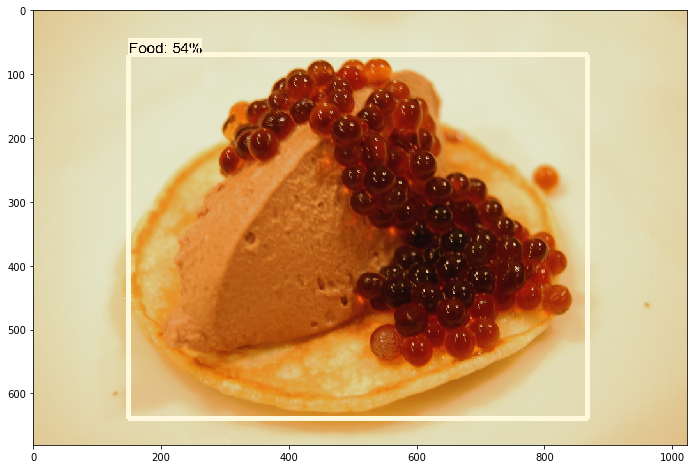

In [21]:
import cv2
from utils import visualization_utils as vis_util
from matplotlib import pyplot as plt
%matplotlib inline

PATH_TO_LABELS = os.path.join('/root/models/research/object_detection/data', 'oid_bbox_trainable_label_map_add2.pbtxt')
NUM_CLASSES = 547
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

#.jpg # v4 model
image_path='/root/raw_images_validation/'+decoded_dict[standard_fields.DetectionResultFields.key]+'.jpg'

# image = Image.open(image_path)
# image_np = load_image_into_numpy_array(image)
image_np = cv2.imread(image_path,1)
image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)


# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)
vis_util.visualize_boxes_and_labels_on_image_array(
  image_np,
  decoded_dict['detection_boxes'],
  decoded_dict['detection_classes'],
  decoded_dict['detection_scores'],
  category_index,
  instance_masks=decoded_dict.get('detection_masks'),
  use_normalized_coordinates=True,
  line_thickness=8,
    min_score_thresh=.5)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)
# print([category_index[x]['name'] for x in decoded_dict['detection_classes'][0:6]])
# print(decoded_dict['detection_scores'][0:6])


080329408b96faa0
[u'Food', u'Baked goods', u'Dessert', u'Pancake', u'Fruit', u'Cake']
[0.54297435 0.30963582 0.23567203 0.08804584 0.08145735 0.08107608]
[u'Pancake', u'Food']


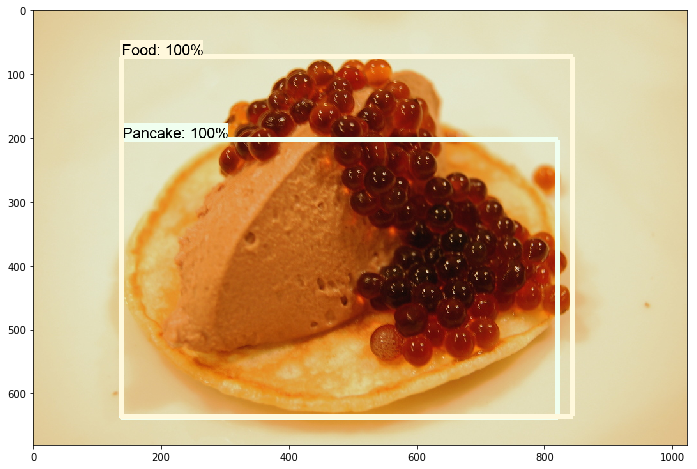

In [22]:
draw_bbox_gt(image_path, decoded_dict)

In [23]:
object_detection_evaluator.evaluate()

  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253
 254 255 256 257 258 259 260 261 262 263 264 265 26

{'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Accordion': nan,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Aircraft': nan,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Airplane': nan,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Alarm clock': nan,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Alpaca': nan,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Ambulance': nan,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Animal': nan,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Ant': nan,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Antelope': nan,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Apple': nan,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Arm': nan,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Artichoke': nan,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Asparagus': nan,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Auto part': nan,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Backpack': nan,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/B

In [13]:
decoded_dict

{'detection_boxes': array([[0.1035452 , 0.1453429 , 0.93941635, 0.84840709],
        [0.11893824, 0.11671975, 0.9221977 , 0.86350578],
        [0.19951402, 0.15265383, 0.93428004, 0.85541058],
        [0.19772248, 0.20276241, 0.89300531, 0.82951015],
        [0.08003771, 0.21335745, 0.86558324, 0.82652754],
        [0.07906909, 0.18037444, 0.90418023, 0.83206588],
        [0.72715235, 0.52272397, 0.80623657, 0.56435317],
        [0.25936729, 0.12984388, 0.94018894, 0.84113699],
        [0.0533051 , 0.15073697, 0.95146036, 0.84831583],
        [0.31896335, 0.48546827, 0.81135714, 0.814695  ],
        [0.30675015, 0.28537709, 0.36906728, 0.32942754],
        [0.1198212 , 0.22668064, 0.87458354, 0.85842538],
        [0.08857033, 0.14569569, 0.88230747, 0.85319978],
        [0.20024949, 0.15573607, 0.87713242, 0.8331275 ],
        [0.09825069, 0.10575575, 0.92537743, 0.85400212],
        [0.08085452, 0.19565326, 0.89570093, 0.90134567],
        [0.10706741, 0.19769138, 0.92749149, 0.832811

In [14]:
object_detection_evaluator._evaluation.num_class 



547

In [15]:
object_detection_evaluator._evaluation.average_false_discover_rate 



array([0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [16]:
object_detection_evaluator._evaluation.false_discover_rate_per_class

[array([0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]),
 array([0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])]

In [17]:
object_detection_evaluator._evaluation.false_negative_rate_per_class

[array([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]),
 array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]

In [43]:
object_detection_evaluator._evaluation.average_false_negative_rate

array([0. , 0.5, 0.5, 0.5, 0.5, 0.5, 1. , 1. , 1. , 1. , 1. ])

In [18]:
##add all grouth class

In [19]:
object_detection_evaluator._evaluation.scores

[array([0.54297435, 0.00335268, 0.00192102, 0.00148535]),
 array([0.08804584, 0.00704393, 0.00239557, 0.00201359])]

In [21]:
object_detection_evaluator._evaluation.tp_fp_labels

[array([ True, False, False, False]), array([ True, False, False, False])]

In [23]:
1-object_detection_evaluator._evaluation.tp_fp_labels[0]

array([0, 1, 1, 1])

In [27]:
scores = object_detection_evaluator._evaluation.scores[0]
np.greater_equal(scores, 0.1)

array([ True, False, False, False])

In [33]:
true_positive_labels=object_detection_evaluator._evaluation.tp_fp_labels[0].astype(int)
false_positive_labels = 1 - true_positive_labels


In [40]:
np.sum(true_positive_labels[np.greater_equal(scores, 0.1)]).astype(float)

1.0

In [42]:
np.sum(false_positive_labels[np.greater_equal(scores, 0.1)]).astype(float)


0.0

In [37]:
np.greater_equal(scores, 0)

array([ True,  True,  True,  True])

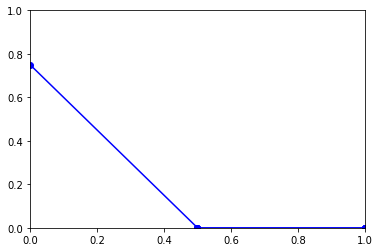

In [51]:
x=object_detection_evaluator._evaluation.average_false_negative_rate
y=object_detection_evaluator._evaluation.average_false_discover_rate
plt.xlim(0, 1.0);
plt.ylim(0, 1.0);

plt.plot(x, y, '-ob');


In [ ]:
# calculate test result

In [24]:
  # new format, train_out_547_1GPU1batch_lrPet, per 2 
  required_flags = ['input_config_path', 'eval_config_path', 'eval_dir']
#   for flag_name in required_flags:
#     if not getattr(FLAGS, flag_name):
#       raise ValueError('Flag --{} is required'.format(flag_name))

  configs = config_util.get_configs_from_multiple_files(
      eval_input_config_path='/root/oid_bbox_trainable_label_map_add2_test_eval_metrics_train_out_547_1GPU1batch_lrPet_frozen_697960_annotations-human-bbox/test_input_config.pbtxt',
      eval_config_path='/root/oid_bbox_trainable_label_map_add2_test_eval_metrics_train_out_547_1GPU1batch_lrPet_frozen_697960_annotations-human-bbox/test_eval_config.pbtxt')

  eval_config = configs['eval_config']
  input_config = configs['eval_input_config']

In [25]:
  if input_config.WhichOneof('input_reader') == 'tf_record_input_reader':
    input_paths = input_config.tf_record_input_reader.input_path

    label_map = label_map_util.load_labelmap(input_config.label_map_path)
    max_num_classes = max([item.id for item in label_map.item])
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes)

    object_detection_evaluators = evaluator.get_evaluators(
        eval_config, categories)
    # Support a single evaluator
    object_detection_evaluator = object_detection_evaluators[0]

    skipped_images = 0
    processed_images = 0

In [26]:
    for input_path in _generate_filenames(input_paths):
      tf.logging.info('Processing file: {0}'.format(input_path))

      record_iterator = tf.python_io.tf_record_iterator(path=input_path)
      data_parser = tf_example_parser.TfExampleDetectionAndGTParser()

      for string_record in record_iterator:
        tf.logging.log_every_n(tf.logging.INFO, 'Processed %d images...', 1000,
                               processed_images)
        processed_images += 1

        example = tf.train.Example()
        example.ParseFromString(string_record)
        decoded_dict = data_parser.parse(example)
#         print(decoded_dict)

        if decoded_dict:
          object_detection_evaluator.add_single_ground_truth_image_info(
              decoded_dict[standard_fields.DetectionResultFields.key],
              decoded_dict)
          object_detection_evaluator.add_single_detected_image_info(
              decoded_dict[standard_fields.DetectionResultFields.key],
              decoded_dict)
        else:
          skipped_images += 1
          tf.logging.info('Skipped images: {0}'.format(skipped_images))
#         break
#       break

INFO:tensorflow:Processing file: /root/oid_bbox_trainable_label_map_add2_train_out_547_1GPU1batch_lrPet_frozen_697960_test_annotations-human-bbox_detections.tfrecord-00000-of-00001


INFO:tensorflow:Processing file: /root/oid_bbox_trainable_label_map_add2_train_out_547_1GPU1batch_lrPet_frozen_697960_test_annotations-human-bbox_detections.tfrecord-00000-of-00001


INFO:tensorflow:Processed 0 images...


INFO:tensorflow:Processed 0 images...


INFO:tensorflow:Processed 1000 images...


INFO:tensorflow:Processed 1000 images...


INFO:tensorflow:Processed 2000 images...


INFO:tensorflow:Processed 2000 images...


INFO:tensorflow:Processed 3000 images...


INFO:tensorflow:Processed 3000 images...


INFO:tensorflow:Processed 4000 images...


INFO:tensorflow:Processed 4000 images...


INFO:tensorflow:Processed 5000 images...


INFO:tensorflow:Processed 5000 images...


INFO:tensorflow:Processed 6000 images...


INFO:tensorflow:Processed 6000 images...


INFO:tensorflow:Processed 7000 images...


INFO:tensorflow:Processed 7000 images...


INFO:tensorflow:Processed 8000 images...


INFO:tensorflow:Processed 8000 images...


INFO:tensorflow:Processed 9000 images...


INFO:tensorflow:Processed 9000 images...


INFO:tensorflow:Processed 10000 images...


INFO:tensorflow:Processed 10000 images...


INFO:tensorflow:Processed 11000 images...


INFO:tensorflow:Processed 11000 images...


INFO:tensorflow:Processed 12000 images...


INFO:tensorflow:Processed 12000 images...


INFO:tensorflow:Processed 13000 images...


INFO:tensorflow:Processed 13000 images...


INFO:tensorflow:Processed 14000 images...


INFO:tensorflow:Processed 14000 images...


INFO:tensorflow:Processed 15000 images...


INFO:tensorflow:Processed 15000 images...


INFO:tensorflow:Processed 16000 images...


INFO:tensorflow:Processed 16000 images...


INFO:tensorflow:Processed 17000 images...


INFO:tensorflow:Processed 17000 images...


INFO:tensorflow:Processed 18000 images...


INFO:tensorflow:Processed 18000 images...


INFO:tensorflow:Processed 19000 images...


INFO:tensorflow:Processed 19000 images...


INFO:tensorflow:Processed 20000 images...


INFO:tensorflow:Processed 20000 images...


INFO:tensorflow:Processed 21000 images...


INFO:tensorflow:Processed 21000 images...


INFO:tensorflow:Processed 22000 images...


INFO:tensorflow:Processed 22000 images...


INFO:tensorflow:Processed 23000 images...


INFO:tensorflow:Processed 23000 images...


INFO:tensorflow:Processed 24000 images...


INFO:tensorflow:Processed 24000 images...


INFO:tensorflow:Processed 25000 images...


INFO:tensorflow:Processed 25000 images...


INFO:tensorflow:Processed 26000 images...


INFO:tensorflow:Processed 26000 images...


INFO:tensorflow:Processed 27000 images...


INFO:tensorflow:Processed 27000 images...


INFO:tensorflow:Processed 28000 images...


INFO:tensorflow:Processed 28000 images...


INFO:tensorflow:Processed 29000 images...


INFO:tensorflow:Processed 29000 images...


INFO:tensorflow:Processed 30000 images...


INFO:tensorflow:Processed 30000 images...


INFO:tensorflow:Processed 31000 images...


INFO:tensorflow:Processed 31000 images...


INFO:tensorflow:Processed 32000 images...


INFO:tensorflow:Processed 32000 images...


INFO:tensorflow:Processed 33000 images...


INFO:tensorflow:Processed 33000 images...


INFO:tensorflow:Processed 34000 images...


INFO:tensorflow:Processed 34000 images...


INFO:tensorflow:Processed 35000 images...


INFO:tensorflow:Processed 35000 images...


INFO:tensorflow:Processed 36000 images...


INFO:tensorflow:Processed 36000 images...


INFO:tensorflow:Processed 37000 images...


INFO:tensorflow:Processed 37000 images...


INFO:tensorflow:Processed 38000 images...


INFO:tensorflow:Processed 38000 images...


INFO:tensorflow:Processed 39000 images...


INFO:tensorflow:Processed 39000 images...


INFO:tensorflow:Processed 40000 images...


INFO:tensorflow:Processed 40000 images...


INFO:tensorflow:Processed 41000 images...


INFO:tensorflow:Processed 41000 images...


INFO:tensorflow:Processed 42000 images...


INFO:tensorflow:Processed 42000 images...


INFO:tensorflow:Processed 43000 images...


INFO:tensorflow:Processed 43000 images...


INFO:tensorflow:Processed 44000 images...


INFO:tensorflow:Processed 44000 images...


INFO:tensorflow:Processed 45000 images...


INFO:tensorflow:Processed 45000 images...


INFO:tensorflow:Processed 46000 images...


INFO:tensorflow:Processed 46000 images...


INFO:tensorflow:Processed 47000 images...


INFO:tensorflow:Processed 47000 images...


INFO:tensorflow:Processed 48000 images...


INFO:tensorflow:Processed 48000 images...


INFO:tensorflow:Processed 49000 images...


INFO:tensorflow:Processed 49000 images...


INFO:tensorflow:Processed 50000 images...


INFO:tensorflow:Processed 50000 images...


INFO:tensorflow:Processed 51000 images...


INFO:tensorflow:Processed 51000 images...


INFO:tensorflow:Processed 52000 images...


INFO:tensorflow:Processed 52000 images...


INFO:tensorflow:Processed 53000 images...


INFO:tensorflow:Processed 53000 images...


INFO:tensorflow:Processed 54000 images...


INFO:tensorflow:Processed 54000 images...


INFO:tensorflow:Processed 55000 images...


INFO:tensorflow:Processed 55000 images...


INFO:tensorflow:Processed 56000 images...


INFO:tensorflow:Processed 56000 images...


INFO:tensorflow:Processed 57000 images...


INFO:tensorflow:Processed 57000 images...


INFO:tensorflow:Processed 58000 images...


INFO:tensorflow:Processed 58000 images...


INFO:tensorflow:Processed 59000 images...


INFO:tensorflow:Processed 59000 images...


INFO:tensorflow:Processed 60000 images...


INFO:tensorflow:Processed 60000 images...


INFO:tensorflow:Processed 61000 images...


INFO:tensorflow:Processed 61000 images...


INFO:tensorflow:Processed 62000 images...


INFO:tensorflow:Processed 62000 images...


INFO:tensorflow:Processed 63000 images...


INFO:tensorflow:Processed 63000 images...


INFO:tensorflow:Processed 64000 images...


INFO:tensorflow:Processed 64000 images...


INFO:tensorflow:Processed 65000 images...


INFO:tensorflow:Processed 65000 images...


INFO:tensorflow:Processed 66000 images...


INFO:tensorflow:Processed 66000 images...


INFO:tensorflow:Processed 67000 images...


INFO:tensorflow:Processed 67000 images...


INFO:tensorflow:Processed 68000 images...


INFO:tensorflow:Processed 68000 images...


INFO:tensorflow:Processed 69000 images...


INFO:tensorflow:Processed 69000 images...


INFO:tensorflow:Processed 70000 images...


INFO:tensorflow:Processed 70000 images...


INFO:tensorflow:Processed 71000 images...


INFO:tensorflow:Processed 71000 images...


INFO:tensorflow:Processed 72000 images...


INFO:tensorflow:Processed 72000 images...


INFO:tensorflow:Processed 73000 images...


INFO:tensorflow:Processed 73000 images...


INFO:tensorflow:Processed 74000 images...


INFO:tensorflow:Processed 74000 images...


INFO:tensorflow:Processed 75000 images...


INFO:tensorflow:Processed 75000 images...


INFO:tensorflow:Processed 76000 images...


INFO:tensorflow:Processed 76000 images...


INFO:tensorflow:Processed 77000 images...


INFO:tensorflow:Processed 77000 images...


INFO:tensorflow:Processed 78000 images...


INFO:tensorflow:Processed 78000 images...


INFO:tensorflow:Processed 79000 images...


INFO:tensorflow:Processed 79000 images...


INFO:tensorflow:Processed 80000 images...


INFO:tensorflow:Processed 80000 images...


INFO:tensorflow:Processed 81000 images...


INFO:tensorflow:Processed 81000 images...


INFO:tensorflow:Processed 82000 images...


INFO:tensorflow:Processed 82000 images...


INFO:tensorflow:Processed 83000 images...


INFO:tensorflow:Processed 83000 images...


INFO:tensorflow:Processed 84000 images...


INFO:tensorflow:Processed 84000 images...


INFO:tensorflow:Processed 85000 images...


INFO:tensorflow:Processed 85000 images...


INFO:tensorflow:Processed 86000 images...


INFO:tensorflow:Processed 86000 images...


INFO:tensorflow:Processed 87000 images...


INFO:tensorflow:Processed 87000 images...


INFO:tensorflow:Processed 88000 images...


INFO:tensorflow:Processed 88000 images...


INFO:tensorflow:Processed 89000 images...


INFO:tensorflow:Processed 89000 images...


INFO:tensorflow:Processed 90000 images...


INFO:tensorflow:Processed 90000 images...


INFO:tensorflow:Processed 91000 images...


INFO:tensorflow:Processed 91000 images...


INFO:tensorflow:Processed 92000 images...


INFO:tensorflow:Processed 92000 images...


INFO:tensorflow:Processed 93000 images...


INFO:tensorflow:Processed 93000 images...


INFO:tensorflow:Processed 94000 images...


INFO:tensorflow:Processed 94000 images...


INFO:tensorflow:Processed 95000 images...


INFO:tensorflow:Processed 95000 images...


INFO:tensorflow:Processed 96000 images...


INFO:tensorflow:Processed 96000 images...


INFO:tensorflow:Processed 97000 images...


INFO:tensorflow:Processed 97000 images...


INFO:tensorflow:Processed 98000 images...


INFO:tensorflow:Processed 98000 images...


INFO:tensorflow:Processed 99000 images...


INFO:tensorflow:Processed 99000 images...


INFO:tensorflow:Processed 100000 images...


INFO:tensorflow:Processed 100000 images...


INFO:tensorflow:Processed 101000 images...


INFO:tensorflow:Processed 101000 images...


INFO:tensorflow:Processed 102000 images...


INFO:tensorflow:Processed 102000 images...


INFO:tensorflow:Processed 103000 images...


INFO:tensorflow:Processed 103000 images...


INFO:tensorflow:Processed 104000 images...


INFO:tensorflow:Processed 104000 images...


INFO:tensorflow:Processed 105000 images...


INFO:tensorflow:Processed 105000 images...


INFO:tensorflow:Processed 106000 images...


INFO:tensorflow:Processed 106000 images...


INFO:tensorflow:Processed 107000 images...


INFO:tensorflow:Processed 107000 images...


INFO:tensorflow:Processed 108000 images...


INFO:tensorflow:Processed 108000 images...


In [27]:
object_detection_evaluator.evaluate()

{'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Accordion': 0.9614267832381784,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Aircraft': 0.09264132531672056,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Airplane': 0.8090170979348443,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Alarm clock': 0.7640737928280895,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Alpaca': 0.7510881828002469,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Ambulance': 0.5996930378203584,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Animal': 0.03224405013845779,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Ant': 0.5773782551475678,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Antelope': 0.7422653642948951,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Apple': 0.37671441843134573,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Arm': 0.17769576905166473,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Artichoke': 0.696318355576075,
 'OpenImagesV2_PerformanceByCategory/AP@0.01IOU/Asparagus': 

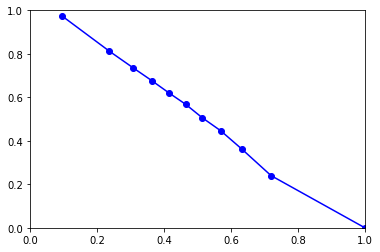

In [28]:
x=object_detection_evaluator._evaluation.average_false_negative_rate
y=object_detection_evaluator._evaluation.average_false_discover_rate
plt.xlim(0, 1.0);
plt.ylim(0, 1.0);
# IMAGE_SIZE = (12, 8)
# plt.figure(figsize=IMAGE_SIZE)

# plt.figure(figsize=IMAGE_SIZE, dpi=80)

plt.plot(x, y, '-ob');
plt.savefig('/root/FNR_001.png', transparent=False, dpi = 300)


In [32]:
import pickle 
object_pi = object_detection_evaluator
file_pi = open('/root/object_detection_evaluator_697960_001.obj', 'w') 
pickle.dump(object_pi, file_pi)

In [33]:
object_pi = object_detection_evaluator._evaluation.average_false_negative_rate
file_pi = open('/root/object_detection_evaluator_697960_fnr_001.obj', 'w') 
pickle.dump(object_pi, file_pi)

In [34]:
object_pi = object_detection_evaluator._evaluation.average_false_discover_rate
file_pi = open('/root/object_detection_evaluator_697960_fdr_001.obj', 'w') 
pickle.dump(object_pi, file_pi)

In [74]:
print(object_detection_evaluator._evaluation.average_false_negative_rate)

[0.14216381 0.27639196 0.34221265 0.39596626 0.44293065 0.49018528
 0.53610725 0.58786883 0.64698087 0.7295914  1.        ]


In [75]:
print(object_detection_evaluator._evaluation.average_false_discover_rate)

[0.9749045  0.82123418 0.74964249 0.69296274 0.64004905 0.59074784
 0.53085152 0.47106714 0.38878827 0.26701657 0.        ]


In [29]:
print(object_detection_evaluator._evaluation.average_false_negative_rate)

[0.09628519 0.2371611  0.30745496 0.36392285 0.41434121 0.4647991
 0.51392173 0.56969459 0.63259203 0.71964087 1.        ]


In [30]:
print(object_detection_evaluator._evaluation.average_false_discover_rate)

[0.97325368 0.81182163 0.73615314 0.67637881 0.62082597 0.56783924
 0.50656146 0.44597449 0.36198189 0.2401938  0.        ]


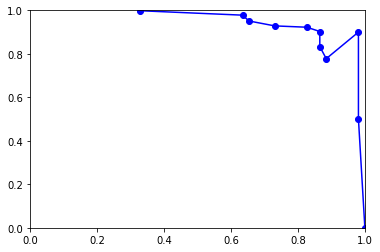

In [31]:
x=object_detection_evaluator._evaluation.false_negative_rate_per_class[544]
y=object_detection_evaluator._evaluation.false_discover_rate_per_class[544]
plt.xlim(0, 1.0);
plt.ylim(0, 1.0);
# IMAGE_SIZE = (12, 8)
# plt.figure(figsize=IMAGE_SIZE)

# plt.figure(figsize=IMAGE_SIZE, dpi=80)

plt.plot(x, y, '-ob');

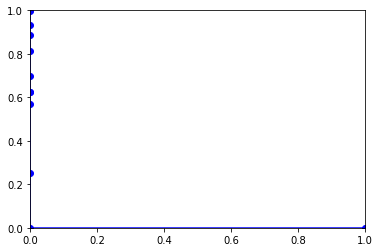

In [78]:
x=object_detection_evaluator._evaluation.false_negative_rate_per_class[543]
y=object_detection_evaluator._evaluation.false_discover_rate_per_class[543]
plt.xlim(0, 1.0);
plt.ylim(0, 1.0);
# IMAGE_SIZE = (12, 8)
# plt.figure(figsize=IMAGE_SIZE)

# plt.figure(figsize=IMAGE_SIZE, dpi=80)

plt.plot(x, y, '-ob');